In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

## Ladda och Förbered Data

In [2]:
# Ladda data
df = pd.read_csv("housing.csv")

# Rensa null-värden
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

# Skapa nya funktioner för att ge mer insikter om hushållens sammansättning och användning av rum
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# Ändra ocean_proximity till kategorier
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

## Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Träna och Utvärdera XGBoost-Modellen

In [4]:
# Skapa och träna en XGBoost-modell
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Utvärdera XGBoost-modellen
y_pred_xgb = xgb_reg.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)

print("XGBoost RMSE: ", xgb_rmse)

XGBoost RMSE:  47135.70579715977


## Hyperparameteroptimering

In [5]:
# Definiera parametergrid för GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Skapa en XGBoost-regressor
xgb_reg = XGBRegressor(random_state=42)

# Skapa en GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [6]:
# Träna GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [7]:
# Hitta de bästa parametervärdena
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [8]:
# Använd de bästa parametervärdena för att träna en ny XGBoost-modell
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# Utvärdera den bästa XGBoost-modellen
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_mse = mean_squared_error(y_test, y_pred_best_xgb)
best_xgb_rmse = np.sqrt(best_xgb_mse)

In [10]:
print("Best XGBoost RMSE: ", best_xgb_rmse)

Best XGBoost RMSE:  46245.39364379003


In [11]:
# Beräkna R²-värdet
r2 = r2_score(y_test, y_pred_best_xgb)
print("R²-värde:", r2)

R²-värde: 0.8367962621761023


In [12]:
# Beräkna relativ RMSE
mean_actual = np.mean(y_test)
relative_rmse = (best_xgb_rmse / mean_actual) * 100
print("Relativ RMSE (%):", relative_rmse)

Relativ RMSE (%): 22.503807286410073


## Visualisera Modellens Prestanda

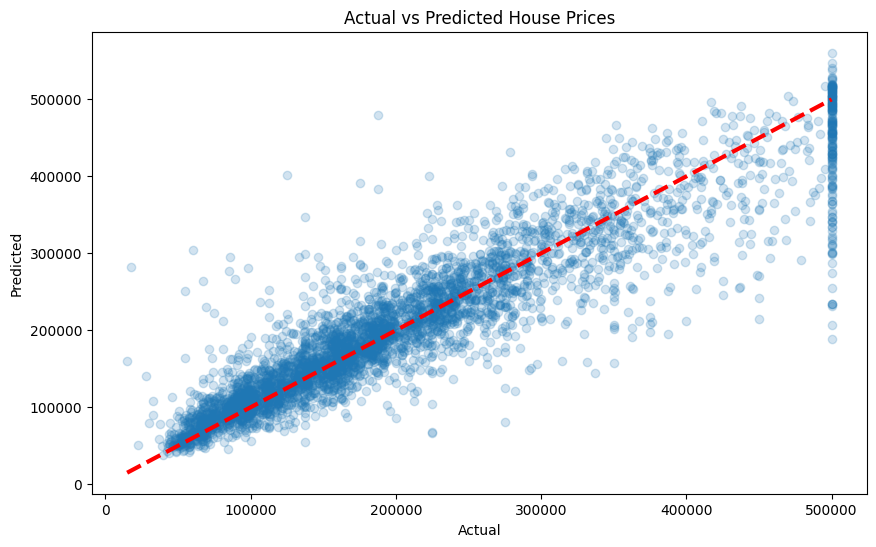

In [13]:
# Plot the actual vs predicted house prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_xgb, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted House Prices')
plt.show()

Ett RMSE-värde på 46245.39 indikerar hur mycket de förutspådda huspriserna i genomsnitt skiljer sig från de faktiska huspriserna. Ju lägre RMSE, desto mer precisa är förutsägelser.